# Intro to Converse API

> *This notebook should work well with the **`conda_python3`** kernel in SageMaker Studio on ml.t3.medium instance*

---

In the prior notebook, we invoked models using the `invoke_model` API. In this notebook we'll explore the converse API which offers several advantages over the invoke API including:
- Standardized inputs and outputs across all models
- Better conversation handling via the standardize `message` format
- Access to additional functionality such as `tool_usage`


---

In [4]:
import sys
import os
module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils.environment_validation import validate_environment, validate_model_access
validate_environment()

Validating base environment
Base environment validated successfully


Validating lab environment from requirements.txt ✨

ENVIRONMENT STATUS
✅  boto3>=1.37.22, <2.0.0 is installed
✅  botocore>=1.37.22, <2.0.0 is installed

All required libraries are installed.🎉
You may proceed with the lab! 🚀

In [5]:
required_models = [
    "us.anthropic.claude-3-5-haiku-20241022-v1:0",
    "us.anthropic.claude-3-5-sonnet-20241022-v2:0",
    "us.amazon.nova-pro-v1:0",
]
validate_model_access(required_models)

MODEL ACCESS STATUS
✅  us.anthropic.claude-3-5-haiku-20241022-v1:0 is accessible
✅  us.anthropic.claude-3-5-sonnet-20241022-v2:0 is accessible
✅  us.amazon.nova-pro-v1:0 is accessible

All required models are accessible.🎉
You may proceed with the lab! 🚀

In [6]:
# used to interact with AWS APIs
import boto3

# used for pretty printing
from rich import print as rprint
from rich.markdown import Markdown, Syntax

bedrock = boto3.client("bedrock")                   # administrative API used to interact with Bedrock
bedrock_runtime = boto3.client("bedrock-runtime")   # runtime API used to invoke models

# See link for available model IDs: https://docs.aws.amazon.com/bedrock/latest/userguide/models-supported.html
MODEL_ID = "us.amazon.nova-pro-v1:0" # you can change this to any model you have access to and everything should work without any code changes

# See link for available inference configurations: https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InferenceConfiguration.html
INFERENCE_CONFIG = {
    "maxTokens": 1000,
    "temperature": 0,
}

### Invoke model with text prompt

We start with the simplest example of invoking a model with a text prompt. We will use the [converse](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_Converse.html) API to interact with the model.
The converse API provides a consistent way to interact with different models offered by Bedrock. Each model may have a different set of supported features and modalities which are documented [here](https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference-supported-models-features.html).

In [7]:
# our prompt
input_text = """What does the ratio that contains a company's cash flow from operations in its numerator and
cash outflows from investing and financing activities in its denominator measure?"""

# each input and response are represented as a message JSON object
text_prompt_message = {
    "role": "user", # inputs come from the user, responses come from the assistant
    "content": [
        { "text": input_text },
        ]
}

# the api expects a list of messages for the entire conversation
# you'd add more messages to this list if you were continuing a conversation
text_prompt_messages = [text_prompt_message]

# invoke the model
text_prompt_response = bedrock_runtime.converse(
        modelId=MODEL_ID,
        inferenceConfig=INFERENCE_CONFIG,
        messages=text_prompt_messages
    )

# extract the text output from the response
text_prompt_output = text_prompt_response["output"]["message"]["content"][0]["text"]

rprint(Markdown(text_prompt_output))

The ratio that contains a company's cash flow from operations in the numerator and cash outflows from investing and
financing activities in the denominator is known as the Cash Flow Coverage Ratio. This ratio is used to assess a   
company's ability to cover its investing and financing cash outflows using the cash generated from its operations. 

                                                     Formula:                                                      

[ \text{Cash Flow Coverage Ratio} = \frac{\text{Cash Flow from Operations}}{\text{Cash Outflows from Investing and 
Financing Activities}} ]                                                                                           

                                                  Interpretation:                                                  

 • Greater than 1: Indicates that the company generates sufficient cash from its operations to cover its investing 
   and financing needs. This is generally a positive sign of financial health.                                     
 • Equal to 1: Suggests that the company’s operational cash flow exactly matches its cash outflows for investing   
   and financing activities. This leaves little room for error or unexpected expenses.                             
 • Less than 1: Implies that the company does not generate enough cash from operations to cover its investing and  
   financing outflows. This could be a red flag, indicating potential cash flow problems.                          

                                                    Importance:                                                    

 • Financial Health: Provides insight into the company’s ability to sustain its operations and growth initiatives  
   without relying heavily on external financing.                                                                  
 • Risk Assessment: Helps investors and creditors assess the risk associated with the company’s cash flow          
   management.                                                                                                     
 • Operational Efficiency: Reflects how effectively the company is converting its operations into cash to fund its 
   growth and financial obligations.                                                                               

In summary, the Cash Flow Coverage Ratio is a vital metric for evaluating a company's financial stability and      
operational efficiency.

### Invoke model with an image prompt

Certain models can also be invoked with image data. This can be useful for tasks like image captioning, or extracting data from documents without having to convert them to text through OCR.
Let's load and example image and provide it as part of our prompt.

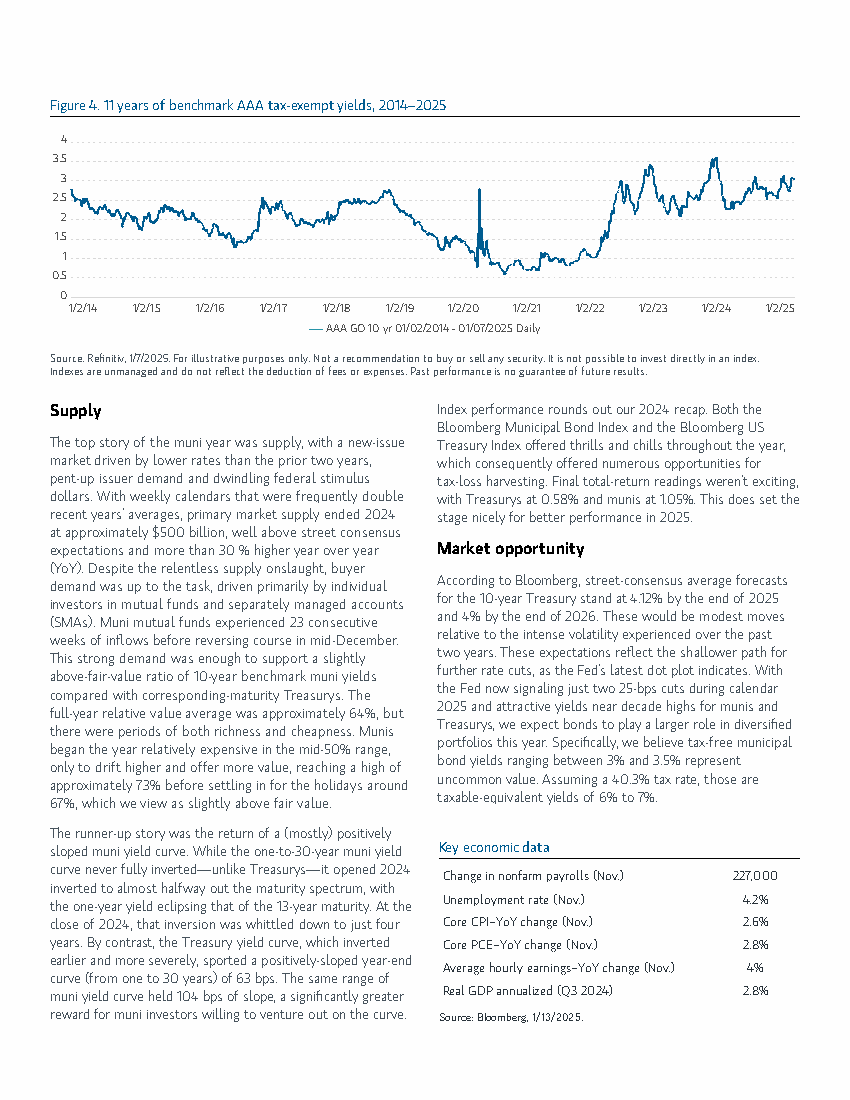

In [8]:
from PIL import Image
from io import BytesIO 
from pathlib import Path
image_path = "data/yield_report_page_3.png"
image = Image.open(image_path)
image.show()

image_bytes = BytesIO()
image.save(image_bytes, format="PNG")
image_bytes = image_bytes.getvalue()

In [ ]:
image_example_text_prompt = """Provide a table and an analysis of the yield trends of AAA rated bonds from 2020 to 2025"""

image_prompt_message = {
    "role": "user",
    "content": [
        {"text": image_example_text_prompt},  # text component of the message
        {
            "image": {
                "format": "png",
                "source": {"bytes": image_bytes},
            },  # image component of the message. Images can be passed as bytes, URLs, or base64 strings
        },
    ],
}

image_prompt_messages = [image_prompt_message]


image_prompt_response = bedrock_runtime.converse(
    modelId=MODEL_ID, inferenceConfig=INFERENCE_CONFIG, messages=image_prompt_messages
)

image_prompt_output = image_prompt_response["output"]["message"]["content"][0]["text"]

rprint(Markdown(image_prompt_output))

### Invoke model with PDF prompt
Models can also work directly with documents of various formats such as PDF, MD, DOC, DOCX, XLSX. See [here](https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base-chatdoc.html) for more details on supported document formats.

**Note**: This functionality is mostly useful for enabling document chat where a user can upload a document and ask questions about it. It is not recommended for more complex IDP use-cases where additional pre-processing is required.

In [ ]:
doc_file_path = (
    "data/Amazon-com-Inc-2023-Shareholder-Letter.pdf"
)

doc_bytes = Path(doc_file_path).read_bytes()

doc_example_text_prompt = """What were some key Amazon product launches in 2023?"""

doc_prompt_message = {
    "role": "user",
    "content": [
        {"text": doc_example_text_prompt},
        {
            "document": {
                "name": "Amazon 2023 Shareholder Letter",
                "format": "pdf",
                "source": {"bytes": doc_bytes},
            },
        },
    ],
}

doc_prompt_messages = [doc_prompt_message]


doc_prompt_response = bedrock_runtime.converse(
    modelId=MODEL_ID, inferenceConfig=INFERENCE_CONFIG, messages=doc_prompt_messages
)

doc_prompt_output = doc_prompt_response["output"]["message"]["content"][0]["text"]

rprint(Markdown(doc_prompt_output))

### Invoke Model with Tool Use
Tool usage is a powerful feature that enables developers to augment the model's capabilities with customized external tools. Underpinning this capability is the model's ability to identify which tool to use for a given task, and generate a request to the tool in a format that is consistent with the tool's signature.

In the example below we will create a simple yet powerful tool that can be used to run a python snippet generated by the model and return the output.

> 🚨 **Caution** The example below will enable the model to execute arbitrary python code. This is provided to demonstrate the model's capability to invoke external tools and generate python code and should not be used in production. > Recommended practices for running LLM generated code in production include:
> - Running the code in an isolated sandboxed environment
> - Limiting the execution time and resources available to the code
> - Validating the code before execution
> - Restricting the code to a specific set of libraries

In [ ]:
from tempfile import NamedTemporaryFile
import sys
import os
import subprocess


def run_python_code(code: str) -> str:
    "will run the python code and return the output"
    
    with NamedTemporaryFile(mode="w", delete=False) as f:
        f.write(code)
        f.close()
        
        try:
            result = subprocess.run([sys.executable, f.name], capture_output=True, text=True, check=True)
            return result.stdout
        except subprocess.CalledProcessError as e:
            return e.stderr
        finally:
            os.remove(f.name)

To make the model aware of the available tools, we need to provide the tool's metadata to the model. This metadata includes the tool's name, description, and the input and output formats. The model uses this metadata to generate the request to the tool in a format that is consistent with the tool's signature. Refer to the documentation [here](https://docs.aws.amazon.com/bedrock/latest/userguide/tool-use-inference-call.html) for more details on how to use custom tools use with Bedrock models.

In [ ]:
tool_config = {
    "tools": [
        {
            "toolSpec": {
                "name": "run_python_code",
                "description": f"Runs the provided python code and returns the standard output",
                "inputSchema": {
                    "json": {
                        "type": "object",
                        "properties": {
                            "code": {
                                "type": "string",
                                "description": "A string representing valid python code to be executed"
                            }
                        },
                        "required": [
                            "code"
                        ]
                    }
                }
            }
        }
    ]
}

In [ ]:
# construct a prompt that should trigger a tool
tool_prompt = (
    "Answer the question below. Use tools to help answer any question that requires code or more complex calculations.\n"
    "If using code, make sure the code prints any required responses to the standard output.\n"
    "QUESTION: A 180-day money market instrument is quoted at an add-on rate of 4.76% for a 360-day year. What is the bond equivalent yield of the instrument? Answer as a percentage with two decimal places."
)

tool_prompt_message = {
    "role": "user",
    "content": [
        {"text": tool_prompt},
    ],
}

tool_prompt_messages = [tool_prompt_message]


tool_prompt_response = bedrock_runtime.converse(
    modelId=MODEL_ID,
    inferenceConfig=INFERENCE_CONFIG,
    messages=tool_prompt_messages,
    toolConfig=tool_config,  # add the tool configuration to the request
)

# check if the response contains a tool use 
if tool_prompt_response["stopReason"] == "tool_use":
    message_content = tool_prompt_response["output"]["message"]["content"]
    text_content, tool_content = message_content
    generated_code = tool_content["toolUse"]["input"]["code"]
    rprint(Markdown(f"## LLM Reasoning\n{text_content['text']}"))

    rprint(
        Markdown("## Generated Code"),
        Syntax(generated_code, "python", line_numbers=True, theme="lightbulb"),
    )
    tool_output = run_python_code(generated_code)
    rprint(Markdown("## Tool Output"), Syntax(tool_output, "python", theme="lightbulb"))